In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [3]:
import sklearn

In [4]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [7]:
pos_final_test = pd.read_csv('./data/pos_KNN_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('max')|pos_final_test.columns.str.contains('min')|pos_final_test.columns.str.contains('abn')|pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']



In [8]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [9]:
hadm_features

,"('min', 'Anion Gap - Blood - Chemistry')","('min', 'Bicarbonate - Blood - Chemistry')","('min', 'Calcium, Total - Blood - Chemistry')","('min', 'Chloride - Blood - Chemistry')","('min', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('min', 'Creatinine - Blood - Chemistry')","('min', 'Glucose - Blood - Chemistry')","('min', 'Magnesium - Blood - Chemistry')","('min', 'Phosphate - Blood - Chemistry')","('min', 'Potassium - Blood - Chemistry')","('min', 'Sodium - Blood - Chemistry')","('min', 'Troponin T - Blood - Chemistry')","('min', 'Urea Nitrogen - Blood - Chemistry')","('min', 'Hematocrit - Blood - Hematology')","('min', 'Hemoglobin - Blood - Hematology')","('min', 'MCH - Blood - Hematology')","('min', 'MCHC - Blood - Hematology')","('min', 'MCV - Blood - Hematology')","('min', 'Platelet Count - Blood - Hematology')","('min', 'PT - Blood - Hematology')","('min', 'RDW - Blood - Hematology')","('min', 'Red Blood Cells - Blood - Hematology')","('min', 'White Blood Cells - Blood - Hematology')","('min', 'Bilirubin - Urine - Hematology')","('max', 'Anion Gap - Blood - Chemistry')","('max', 'Bicarbonate - Blood - Chemistry')","('max', 'Calcium, Total - Blood - Chemistry')","('max', 'Chloride - Blood - Chemistry')","('max', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('max', 'Creatinine - Blood - Chemistry')","('max', 'Glucose - Blood - Chemistry')","('max', 'Magnesium - Blood - Chemistry')","('max', 'Phosphate - Blood - Chemistry')","('max', 'Potassium - Blood - Chemistry')","('max', 'Sodium - Blood - Chemistry')","('max', 'Troponin T - Blood - Chemistry')","('max', 'Urea Nitrogen - Blood - Chemistry')","('max', 'Hematocrit - Blood - Hematology')","('max', 'Hemoglobin - Blood - Hematology')","('max', 'MCH - Blood - Hematology')","('max', 'MCHC - Blood - Hematology')","('max', 'MCV - Blood - Hematology')","('max', 'Platelet Count - Blood - Hematology')","('max', 'PT - Blood - Hematology')","('max', 'RDW - Blood - Hematology')","('max', 'Red Blood Cells - Blood - Hematology')","('max', 'White Blood Cells - Blood - Hematology')","('max', 'Bilirubin - Urine - Hematology')","('mean', 'Anion Gap - Blood - Chemistry')","('mean', 'Bicarbonate - Blood - Chemistry')","('mean', 'Calcium, Total - Blood - Chemistry')","('mean', 'Chloride - Blood - Chemistry')","('mean', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('mean', 'Creatinine - Blood - Chemistry')","('mean', 'Glucose - Blood - Chemistry')","('mean', 'Magnesium - Blood - Chemistry')","('mean', 'Phosphate - Blood - Chemistry')","('mean', 'Potassium - Blood - Chemistry')","('mean', 'Sodium - Blood - Chemistry')","('mean', 'Troponin T - Blood - Chemistry')","('mean', 'Urea Nitrogen - Blood - Chemistry')","('mean', 'Hematocrit - Blood - Hematology')","('mean', 'Hemoglobin - Blood - Hematology')","('mean', 'MCH - Blood - Hematology')","('mean', 'MCHC - Blood - Hematology')","('mean', 'MCV - Blood - Hematology')","('mean', 'Platelet Count - Blood - Hematology')","('mean', 'PT - Blood - Hematology')","('mean', 'RDW - Blood - Hematology')","('mean', 'Red Blood Cells - Blood - Hematology')","('mean', 'White Blood Cells - Blood - Hematology')","('mean', 'Bilirubin - Urine - Hematology')","('abn_percent', 'Anion Gap - Blood - Chemistry')","('abn_percent', 'Bicarbonate - Blood - Chemistry')","('abn_percent', 'Calcium, Total - Blood - Chemistry')","('abn_percent', 'Chloride - Blood - Chemistry')","('abn_percent', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('abn_percent', 'Creatinine - Blood - Chemistry')","('abn_percent', 'Glucose - Blood - Chemistry')","('abn_percent', 'Magnesium - Blood - Chemistry')","('abn_percent', 'Phosphate - Blood - Chemistry')","('abn_percent', 'Potassium - Blood - Chemistry')","('abn_percent', 'Sodium - Blood - Chemistry')","('abn_percent', 'Troponin T - Blood - Chemistry')","('abn_percent', 'Urea Nitrogen - Blood - Chemistry')","('abn_percent', 'Hematocrit - Blood - Hematology')","('abn_percent', 'Hemoglobin - Blood - Hematology

## Train test split

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [11]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [12]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7533
Target=1:  1199


In [13]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [14]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')

## Logistic Regression

### Basic

In [15]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log.fit(X_train, y_train)

CPU times: user 4min 51s, sys: 8.4 s, total: 5min
Wall time: 7min 39s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.06210526315789474}
Best CV score:  0.8730
Accuracy Score: 81.34%
_______________________________________________
Classification Report:	Precision Score: 40.57%
			Recall Score: 77.08%
			F1 score: 53.16%
			ROC_AUC score: 79.55%
_______________________________________________
Confusion Matrix: 
 [[1236  271]
 [  55  185]]



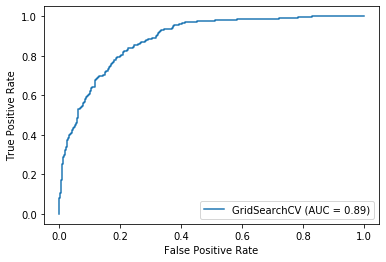

age                                                     0.760464
('max', 'Bicarbonate - Blood - Chemistry')              0.410612
('above_max', 'RDW - Blood - Hematology')               0.382602
('max', 'RDW - Blood - Hematology')                     0.365035
('below_min', 'Urea Nitrogen - Blood - Chemistry')      0.307549
('max', 'Anion Gap - Blood - Chemistry')                0.259485
('max', 'Potassium - Blood - Chemistry')                0.259139
('min', 'RDW - Blood - Hematology')                     0.225516
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')    0.214903
('mean', 'Urea Nitrogen - Blood - Chemistry')           0.194740
('min', 'Glucose - Blood - Chemistry')                  0.192956
('above_max', 'Sodium - Blood - Chemistry')             0.185820
('mean', 'Chloride - Blood - Chemistry')                0.184278
('min', 'MCHC - Blood - Hematology')                    0.177065
('above_max', 'PT - Blood - Hematology')                0.176575
gender                   

In [20]:
%%time
results(grid_log)

In [ ]:
plot_val_curve(estimator, feature, feature_range, X, y)

In [17]:
# from sklearn.feature_selection import RFECV
# selector = RFECV(grid_log, step=1, cv=5)
# selector = selector.fit(X_train, y_train)
# selector.support_

### Over Sampling using SMOTE

In [21]:
%%time
params ={'C':np.linspace(1e-2,1,10)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 3min 52s, sys: 5.87 s, total: 3min 58s
Wall time: 4min 44s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 1.0}
Best CV score:  0.8978
Accuracy Score: 80.42%
_______________________________________________
Classification Report:	Precision Score: 38.72%
			Recall Score: 72.92%
			F1 score: 50.58%
			ROC_AUC score: 77.27%
_______________________________________________
Confusion Matrix: 
 [[1230  277]
 [  65  175]]



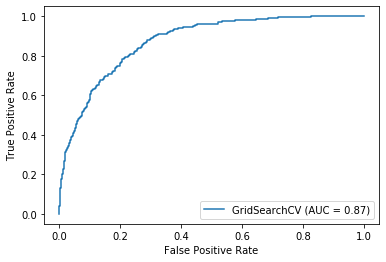

('max', 'Glucose - Blood - Chemistry')                                6.407006
('above_max', 'Glucose - Blood - Chemistry')                          6.239011
('above_max', 'PT - Blood - Hematology')                              2.188717
('max', 'PT - Blood - Hematology')                                    2.047570
('max', 'Magnesium - Blood - Chemistry')                              1.438777
('max', 'Urea Nitrogen - Blood - Chemistry')                          1.404967
('min', 'Red Blood Cells - Blood - Hematology')                       1.378557
('above_max', 'Magnesium - Blood - Chemistry')                        1.312302
('above_max', 'Creatinine - Blood - Chemistry')                       1.233775
('above_max', 'Urea Nitrogen - Blood - Chemistry')                    1.224310
('max', 'Creatinine - Blood - Chemistry')                             1.119029
('above_max', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')    1.081700
('mean', 'Red Blood Cells - Blood - Hematology')    

In [22]:
results(grid_log_over)

### Under Sampling using Near Miss

In [25]:
%%time
params ={'C':np.linspace(1e-2,1,10)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_under.fit(X_res_under, y_res_under)

CPU times: user 2.81 s, sys: 393 ms, total: 3.21 s
Wall time: 2.22 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.12}
Best CV score:  0.9381
Accuracy Score: 70.06%
_______________________________________________
Classification Report:	Precision Score: 29.64%
			Recall Score: 85.83%
			F1 score: 44.06%
			ROC_AUC score: 76.69%
_______________________________________________
Confusion Matrix: 
 [[1018  489]
 [  34  206]]



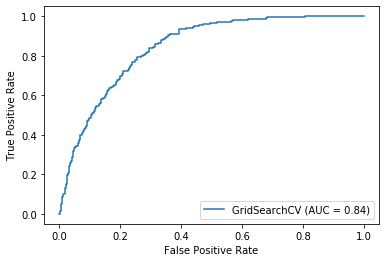

age                                                     1.187974
('min', 'MCHC - Blood - Hematology')                    0.481423
('abn_percent', 'MCH - Blood - Hematology')             0.430324
('min', 'RDW - Blood - Hematology')                     0.415222
('max', 'Potassium - Blood - Chemistry')                0.413900
('min', 'Chloride - Blood - Chemistry')                 0.412841
('abn_percent', 'Bicarbonate - Blood - Chemistry')      0.342297
('above_max', 'Phosphate - Blood - Chemistry')          0.339064
('abn_percent', 'MCHC - Blood - Hematology')            0.324170
gender                                                  0.312435
('mean', 'RDW - Blood - Hematology')                    0.299525
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')    0.299364
('mean', 'Glucose - Blood - Chemistry')                 0.297211
('below_min', 'Hematocrit - Blood - Hematology')        0.261519
('below_min', 'Urea Nitrogen - Blood - Chemistry')      0.259146
('abn_percent', 'Creatini

In [26]:
results(grid_log_under)

## Random Forest

### RF_Over Sampling using SMOTE

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 35, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


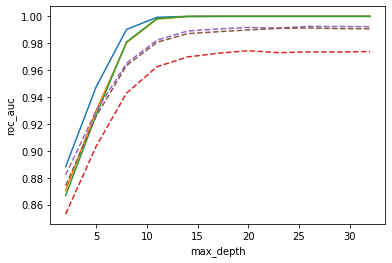

In [27]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_over, y_res_over)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_estimators, param_range=range(10, 1000, 100) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


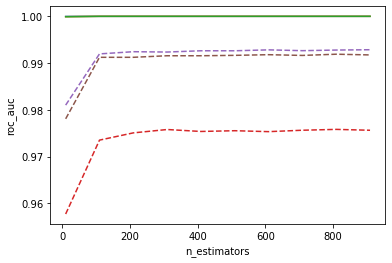

In [30]:
plot_val_curve(RandomForestClassifier(), 'n_estimators', range(10,300,100), X_res_over, y_res_over)

In [31]:
%%time
param_grid={'n_estimators': range(200,201,1),
            'max_depth': range(8,15,3)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 1min 37s, sys: 2.4 s, total: 1min 39s
Wall time: 1min 53s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(8, 15, 3),
                         'n_estimators': range(200, 201)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 200}
Best CV score:  0.9823
Accuracy Score: 86.55%
_______________________________________________
Classification Report:	Precision Score: 50.97%
			Recall Score: 55.00%
			F1 score: 52.91%
			ROC_AUC score: 73.29%
_______________________________________________
Confusion Matrix: 
 [[1380  127]
 [ 108  132]]



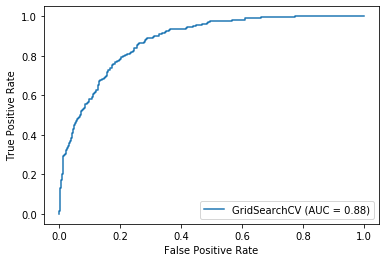

('above_max', 'Urea Nitrogen - Blood - Chemistry')      0.066526
age                                                     0.060393
('max', 'Urea Nitrogen - Blood - Chemistry')            0.044095
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')    0.039905
('mean', 'Urea Nitrogen - Blood - Chemistry')           0.027634
('max', 'Creatinine - Blood - Chemistry')               0.022717
('above_max', 'Creatinine - Blood - Chemistry')         0.022174
('max', 'RDW - Blood - Hematology')                     0.020282
('min', 'Urea Nitrogen - Blood - Chemistry')            0.020236
('abn_percent', 'Creatinine - Blood - Chemistry')       0.019367
('abn_percent', 'Troponin T - Blood - Chemistry')       0.015425
('abn_percent', 'RDW - Blood - Hematology')             0.013857
('above_max', 'RDW - Blood - Hematology')               0.013724
('min', 'MCHC - Blood - Hematology')                    0.013546
('below_min', 'MCHC - Blood - Hematology')              0.011861
('max', 'Bicarbonate - Bl

In [32]:
results(grid_rf_over)

### RF_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 20, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


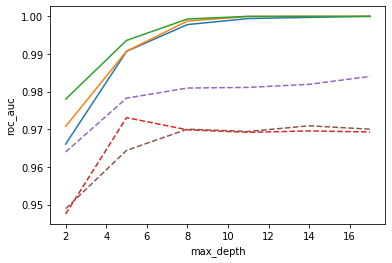

In [33]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,20,3), X_res_under, y_res_under)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_estimators, param_range=range(75, 200, 50) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


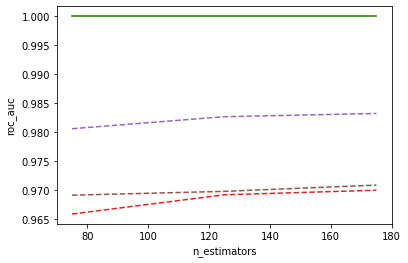

In [35]:
plot_val_curve(RandomForestClassifier(), 'n_estimators', range(75,200,50), X_res_under, y_res_under)

In [36]:
%%time
param_grid={'n_estimators': range(200,201,1),
            'max_depth': range(3,7,1)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 11.2 s, sys: 248 ms, total: 11.4 s
Wall time: 13.4 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(3, 7),
                         'n_estimators': range(200, 201)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 6, 'n_estimators': 200}
Best CV score:  0.9728
Accuracy Score: 60.68%
_______________________________________________
Classification Report:	Precision Score: 24.52%
			Recall Score: 89.58%
			F1 score: 38.50%
			ROC_AUC score: 72.83%
_______________________________________________
Confusion Matrix: 
 [[845 662]
 [ 25 215]]



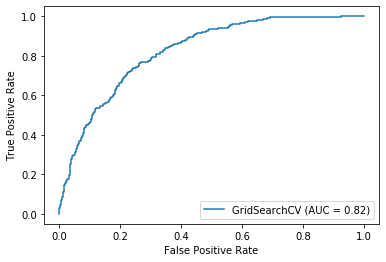

('max', 'Urea Nitrogen - Blood - Chemistry')             0.065703
('min', 'MCHC - Blood - Hematology')                     0.052684
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')     0.051227
('max', 'RDW - Blood - Hematology')                      0.046198
('mean', 'Urea Nitrogen - Blood - Chemistry')            0.045449
('min', 'Chloride - Blood - Chemistry')                  0.036103
('mean', 'RDW - Blood - Hematology')                     0.034542
('above_max', 'Urea Nitrogen - Blood - Chemistry')       0.030805
('abn_percent', 'PT - Blood - Hematology')               0.028155
('min', 'Red Blood Cells - Blood - Hematology')          0.026576
('min', 'Bicarbonate - Blood - Chemistry')               0.025944
('min', 'Hemoglobin - Blood - Hematology')               0.024388
('min', 'Urea Nitrogen - Blood - Chemistry')             0.022430
('mean', 'MCHC - Blood - Hematology')                    0.021614
('below_min', 'Hemoglobin - Blood - Hematology')         0.021539
('max', 'A

In [37]:
results(grid_rf_under)

## Gradient Boost

### GB_Over Sampling using SMOTE¶

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(3, 20, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


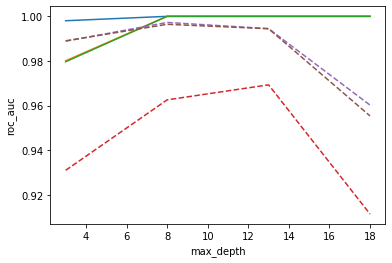

In [38]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(3,20,5), X_res_over, y_res_over)

In [ ]:
%%time
param_grid={'n_estimators': range(250,251,1),
            'max_depth': range(8,13,1)
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid,
                                            cv=3, scoring='roc_auc')
grid_gb_over.fit(X_res_over, y_res_over)

In [ ]:
results(grid_gb_over)

In [237]:
# %%time
# param_grid={'n_estimators':range(150,151,1),
#             'max_depth':range(13,14,1),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(8,17,2),
#             }
# # 'max_depth': 9, 'n_estimators': 80
# grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_over.fit(X_res_over, y_res_over)

In [238]:
# results(grid_gb_over)

### GB_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 7) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


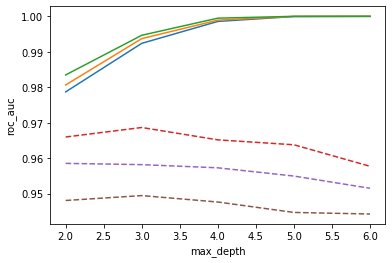

In [240]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(2,7,1),X_res_under, y_res_under)

In [ ]:
%%time
param_grid={'n_estimators':range(250,251,1),
            'max_depth':range(2,9,2),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

In [ ]:
results(grid_gb_under)

In [241]:
# %%time
# param_grid={'n_estimators':range(80,81,1),
#             'max_depth':range(2,9,2),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(7,12,2),
#             }

# grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_under.fit(X_res_under, y_res_under)

In [242]:
# results(grid_gb_under)

## Gather Metrics

In [265]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
#         print(model_name,' processed')
    return metrics

In [ ]:
model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over'), 
            (grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
            (grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
           ]
gather_metrics(model_list)

## Gather Best Features

In [ ]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [ ]:
gather_best_features(model_list)